In [1]:
import os
import struct
import sys
from easydict import EasyDict as edict

import matplotlib.pyplot as plt
import numpy as np

import mindspore
import mindspore.dataset as ds
import mindspore.nn as nn
from mindspore import context
from mindspore.nn.metrics import Accuracy
from mindspore.train import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
from mindspore import Tensor

context.set_context(mode=context.GRAPH_MODE, device_target='Ascend')

In [2]:
cfg = edict({
    'train_size': 60000,  # 训练集大小
    'test_size': 10000,  # 测试集大小
    'channel': 1,  # 图片通道数
    'image_height': 28,  # 图片高度
    'image_width': 28,  # 图片宽度
    'batch_size': 60,
    'num_classes': 10,  # 分类类别
    'lr': 0.001,  # 学习率
    'epoch_size': 20,  # 训练次数
    'data_dir_train': os.path.join('Fashion-MNIST', 'train'),
    'data_dir_test': os.path.join('Fashion-MNIST', 'test'),
    'save_checkpoint_steps': 1,  # 多少步保存一次模型
    'keep_checkpoint_max': 3,  # 最多保存多少个模型
    'output_directory': './model_fashion',  # 保存模型路径
    'output_prefix': "checkpoint_fashion_forward"  # 保存模型文件名字
})

In [3]:
def read_image(file_name):
    '''
    :param file_name: 文件路径
    :return:  训练或者测试数据
    如下是训练的图片的二进制格式
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  60000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
    '''
    file_handle = open(file_name, "rb")  # 以二进制打开文档
    file_content = file_handle.read()  # 读取到缓冲区中
    head = struct.unpack_from('>IIII', file_content, 0)  # 取前4个整数，返回一个元组
    offset = struct.calcsize('>IIII')
    imgNum = head[1]  # 图片数
    width = head[2]  # 宽度
    height = head[3]  # 高度
    bits = imgNum * width * height  # data一共有60000*28*28个像素值
    bitsString = '>' + str(bits) + 'B'  # fmt格式：'>47040000B'
    imgs = struct.unpack_from(bitsString, file_content, offset)  # 取data数据，返回一个元组
    imgs_array = np.array(imgs).reshape((imgNum, width * height))  # 最后将读取的数据reshape成 【图片数，图片像素】二维数组
    return imgs_array


def read_label(file_name):
    '''
    :param file_name:
    :return:
    标签的格式如下：
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  60000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    The labels values are 0 to 9.
    '''
    file_handle = open(file_name, "rb")  # 以二进制打开文档
    file_content = file_handle.read()  # 读取到缓冲区中
    head = struct.unpack_from('>II', file_content, 0)  # 取前2个整数，返回一个元组
    offset = struct.calcsize('>II')
    labelNum = head[1]  # label数
    bitsString = '>' + str(labelNum) + 'B'  # fmt格式：'>47040000B'
    label = struct.unpack_from(bitsString, file_content, offset)  # 取data数据，返回一个元组
    return np.array(label)


def get_data():
    # 文件获取
    train_image = os.path.join(cfg.data_dir_train, 'train-images-idx3-ubyte')
    test_image = os.path.join(cfg.data_dir_test, "t10k-images-idx3-ubyte")
    train_label = os.path.join(cfg.data_dir_train, "train-labels-idx1-ubyte")
    test_label = os.path.join(cfg.data_dir_test, "t10k-labels-idx1-ubyte")
    # 读取数据
    train_x = read_image(train_image)
    test_x = read_image(test_image)
    train_y = read_label(train_label)
    test_y = read_label(test_label)
    return train_x, train_y, test_x, test_y

训练数据集样本数： 60000
测试数据集样本数： 10000
通道数/图像长/宽： (1, 28, 28)
一张图像的标签样式： 9


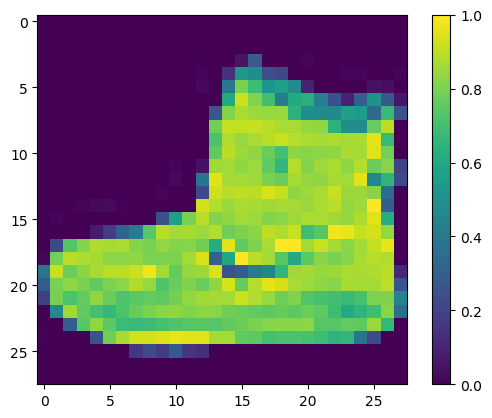

In [5]:
train_x, train_y, test_x, test_y = get_data()
train_x = train_x.reshape(-1, 1, cfg.image_height, cfg.image_width)
test_x = test_x.reshape(-1, 1, cfg.image_height, cfg.image_width)
train_x = train_x / 255.0
test_x = test_x / 255.0
train_x = train_x.astype('Float32')
test_x = test_x.astype('Float32')
train_y = train_y.astype('int32')
test_y = test_y.astype('int32')
print('训练数据集样本数：', train_x.shape[0])
print('测试数据集样本数：', test_y.shape[0])
print('通道数/图像长/宽：', train_x.shape[1:])
print('一张图像的标签样式：', train_y[0])  # 一共10类，用0-9的数字表达类别。

plt.figure()
plt.imshow(train_x[0,0,...])
plt.colorbar()
plt.grid(False)
plt.show()

In [6]:
# 转换数据类型为Dataset
XY_train = list(zip(train_x, train_y))
ds_train = ds.GeneratorDataset(XY_train, ['x', 'y'])
ds_train = ds_train.shuffle(buffer_size=cfg.train_size).batch(cfg.batch_size, drop_remainder=True)
XY_test = list(zip(test_x, test_y))
ds_test = ds.GeneratorDataset(XY_test, ['x', 'y'])
ds_test = ds_test.shuffle(buffer_size=cfg.test_size).batch(cfg.batch_size, drop_remainder=True)

In [7]:
# 定义前馈神经网络
class Forward_fashion(nn.Cell):
    def __init__(self, num_class=10):  # 一共分十类，图片通道数是1
        super(Forward_fashion, self).__init__()
        self.num_class = num_class
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(cfg.channel * cfg.image_height * cfg.image_width, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Dense(128, self.num_class)

    def construct(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [8]:
# 构建网络
network = Forward_fashion(cfg.num_classes)
# 定义模型的损失函数，优化器
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
net_opt = nn.Adam(network.trainable_params(), cfg.lr)
# 训练模型
model = Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={"acc"})
loss_cb = LossMonitor(per_print_times=int(cfg.train_size / cfg.batch_size))
config_ck = CheckpointConfig(save_checkpoint_steps=cfg.save_checkpoint_steps,
                             keep_checkpoint_max=cfg.keep_checkpoint_max)
ckpoint_cb = ModelCheckpoint(prefix=cfg.output_prefix, directory=cfg.output_directory, config=config_ck)
print("============== Starting Training ==============")
model.train(cfg.epoch_size, ds_train, callbacks=[ckpoint_cb, loss_cb], dataset_sink_mode=False)

============== Starting Training ==============
epoch: 1 step: 1000, loss is 0.37865052
epoch: 2 step: 1000, loss is 0.4029348
epoch: 3 step: 1000, loss is 0.34479794
epoch: 4 step: 1000, loss is 0.30702263
epoch: 5 step: 1000, loss is 0.4666077
epoch: 6 step: 1000, loss is 0.31805894
epoch: 7 step: 1000, loss is 0.37157914
epoch: 8 step: 1000, loss is 0.24441308
epoch: 9 step: 1000, loss is 0.26547843
epoch: 10 step: 1000, loss is 0.53147125
epoch: 11 step: 1000, loss is 0.2838583
epoch: 12 step: 1000, loss is 0.20302528
epoch: 13 step: 1000, loss is 0.14008664
epoch: 14 step: 1000, loss is 0.3081509
epoch: 15 step: 1000, loss is 0.33849278
epoch: 16 step: 1000, loss is 0.1864539
epoch: 17 step: 1000, loss is 0.115434796
epoch: 18 step: 1000, loss is 0.25578853
epoch: 19 step: 1000, loss is 0.29839858
epoch: 20 step: 1000, loss is 0.12772429


In [9]:
# 使用测试集评估模型，打印总体准确率
metric = model.eval(ds_test, dataset_sink_mode=False)
print(metric)

{'acc': 0.8848393574297189}


In [11]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#从测试集中取出一组样本，输入模型进行预测
test_ = ds_test.create_dict_iterator()._get_next()
#利用key值选出样本
test = Tensor(test_['x'], mindspore.float32)
predictions = model.predict(test)
softmax = nn.Softmax()
predictions = softmax(predictions)

predictions = predictions.asnumpy()
true_label = test_['y'].asnumpy()
true_image = test_['x'].asnumpy()

for i in range(15):
    p_np = predictions[i, :]
    pre_label = np.argmax(p_np)
    print('第' + str(i) + '个sample预测结果：', class_names[pre_label], '   真实结果：', class_names[true_label[i]])

第0个sample预测结果： Pullover    真实结果： Pullover
第1个sample预测结果： Dress    真实结果： Dress
第2个sample预测结果： Pullover    真实结果： Pullover
第3个sample预测结果： Dress    真实结果： Dress
第4个sample预测结果： Coat    真实结果： Coat
第5个sample预测结果： Ankle boot    真实结果： Ankle boot
第6个sample预测结果： Pullover    真实结果： Shirt
第7个sample预测结果： Sneaker    真实结果： Sneaker
第8个sample预测结果： Shirt    真实结果： Shirt
第9个sample预测结果： Sneaker    真实结果： Sneaker
第10个sample预测结果： Sneaker    真实结果： Sneaker
第11个sample预测结果： Bag    真实结果： Bag
第12个sample预测结果： Ankle boot    真实结果： Ankle boot
第13个sample预测结果： Shirt    真实结果： Shirt
第14个sample预测结果： Sandal    真实结果： Sandal
